In [1]:
import numpy as np
import h5py, pprint
import matplotlib.pyplot as plt

# constants
hbar = 6.626e-34 / (2 * np.pi)     
kB= 1.38e-23

In [2]:
def get_cte(infile, C, T, V, iso, tetra):
    
    '''
    infile: gruniesen.hdf5
    C: elastic stiffness matrix (Pa)
    T: temperature (K)
    V: volume of primitive cell (m^3)
    iso and tetra are checks for symmetry of system and take True/False as argument
    '''
    
    # Load Data
    with h5py.File(infile) as f:
        #pprint.pprint(list(f.keys()))
        freqs_thz = f["frequency"][()] # THZ
        G = np.array(f["gruneisen_tensor"][()]) # Gruneisen TENSOR
        weights = f["weight"][()]
    
    freqs = freqs_thz * 1e12  # Hz
    omegas = freqs * 2*np.pi     
    #print(f'Gruniesen Tensor Shape: {G.shape[:]}')  
    n_qpoints = G.shape[0]
    n_modes = G.shape[1]
    #print(f'There are {n_qpoints} q-points and {n_modes} modes')
    C_inv = np.linalg.inv(C) #inverse of stiffness matrix

    # Heat Capacity
    A = hbar * omegas / (kB * T)
    c_mod = kB * A**2 * ( (np.exp(A))/(np.exp(A)-1)**2 ) # modal heat cap
    #print('Modal Heat Capacity Shape:', c_mod.shape)
    cmod_weighted = c_mod * weights[:, None] # weighted   
    #print('Weighted Modal Heat Capacity Shape:', cmod_weighted.shape)
    c_sum = np.sum(cmod_weighted)
    w_sum = np.sum(weights)
    c_tot = c_sum / w_sum

    # Gruneisen and CTE Calculations
    g_mods = []
    g_mod_xxs = []
    g_mod_zzs = []
    
    if iso == True:
        gc_array = [] # array of products of modal grun and heat cap
        #print('Proceeding for ISOTROPIC/CUBIC symmetry...')
        for q in range(n_qpoints): 
            for m in range(n_modes):

                c = float(cmod_weighted[q, m]) # element of heat cap matrix (float)
                #print('cs shape', cs)
                G_mod = G[q, m]  # second rank 3x3 matrix 
                #print(G_mod)
                #print('G_mod shape',G_mod.shape)
                g_mod = (1/3) * np.trace(G_mod) # scalar gruneisen parameter for specific (q,m)

                gc = g_mod * c # product of modal grun and heat cap
                gc_array.append(gc) 
                
        g_tot = np.sum(gc_array) / c_sum

        cte_lin = (g_tot * c_tot) / (V*(C[0,0] + 2*C[0,1]))
        cte_vol = 3 * cte_lin

        return cte_lin, cte_vol
        sys.exit(0)     

    if tetra == True:
        #print('Proceeding for TETRAHEDRAL symmetry...')
    
        gc_xx_array = []
        gc_zz_array = []
        gc_yy_array = []
        gc_yz_array = []
        gc_xz_array = []
        gc_xy_array = []
        
        for q in range(n_qpoints):       
            for m in range(n_modes):
                c = float(cmod_weighted[q, m]) # element of heat cap matrix (float)
                G_mod = G[q, m]  # second rank 3x3 matrix
                #print(G_mod)
                #TODO: later have this in voigt vector form rather than component wise
                gc_xx = c * G_mod[0, 0]  # xx
                gc_yy = c * G_mod[1, 1]  # yy
                gc_zz = c * G_mod[2, 2]  # zz
                gc_yz = c * G_mod[1, 2]  # yz
                gc_xz = c * G_mod[0, 2]  # xz
                gc_xy = c * G_mod[0, 1]  # xy
              
                gc_xx_array.append(gc_xx)
                gc_zz_array.append(gc_zz)
                gc_yy_array.append(gc_yy)
                gc_yz_array.append(gc_yz)
                gc_xz_array.append(gc_xz)
                gc_xy_array.append(gc_xy)
                
        g_tot_xx = np.sum(gc_xx_array) / (c_sum)
        g_tot_zz = np.sum(gc_zz_array) / (c_sum)

        gtot_vec = np.array([ 
            np.sum(gc_xx_array) / (c_sum),
            np.sum(gc_yy_array) / (c_sum),
            np.sum(gc_zz_array) / (c_sum),
            np.sum(gc_yz_array) / (c_sum),
            np.sum(gc_xz_array) / (c_sum),
            np.sum(gc_xy_array) / (c_sum)
        ])

        cte_vec = (c_tot / V) * (C_inv @ gtot_vec)
        
        cte_lin_xx = cte_vec[0]
        cte_lin_zz = cte_vec[2]
        cte_vol = 2*cte_lin_xx + cte_lin_zz

        return cte_lin_xx, cte_lin_zz, cte_vol, cte_vec 
        sys.exit(0)

## ScF3

In [11]:
# anisotropic
# PARAMETERS
gfile = "/Users/admin/NREL/ScF3/16-gruneisen.hdf5"
stiffness_GPa = np.array([
    [235,  18,  18,   0,   0,   0],
    [ 18, 235,  18,   0,   0,   0],
    [ 18,  18, 235,   0,   0,   0],
    [  0,   0,   0,  18,   0,   0],
    [  0,   0,   0,   0,  18,   0],
    [  0,   0,   0,   0,   0,  18]])
stiffness = stiffness_GPa * 1e9

poscar_matrix = np.array([
                [ 2.8465005904369178,  1.6434278821371833,  2.3242469421120542],
                [-2.8465005904369178,  1.6434278821371833,  2.3242469421120542],
                [-1.0e-16,            -3.2868557642743665,  2.3242469421120542]])

V = np.linalg.det(poscar_matrix) * 1e-30 # volume of primitive cell in m^3

#RUN
temps = np.arange(4, 1200)
cte_vecs = []
vols = []

for t in temps:
    cte_lin_xx, cte_lin_zz, cte_vol, cte_vec  = get_cte(gfile, stiffness, t, V, iso = False, tetra = True)
    cte_vecs.append(cte_vec)
    #vol = 2*np.array(cte_vec[0]) + cte_vec[2]
    vol = cte_vec[0] + cte_vec[1] + cte_vec[2]
    vols.append(vol)

print(f'Volumetric CTE Minima: {float(np.min(np.array(vols))) * 1e6} ppm/K')

Volumetric CTE Minima: -42.445983704823384 ppm/K


In [12]:
#references

import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

exp_dat = """
66.00660664542269, -13.775914167686661
78.55043815683959, -13.37236459608323
91.09468382011565, -12.972418145654839
103.01441148815641, -12.615909322725418
115.5584647172353, -12.214288694781352
128.73487554340952, -11.837434975520196
141.90737075200585, -11.42651538333148
155.71293472755676, -11.046549877600981
169.51755744888212, -10.658395460109048
183.3225566718978, -10.273516607321689
197.13000315589957, -9.909928925114055
210.9389556466621, -9.559443501724715
224.74583737812858, -9.190942472460222
238.55799013325768, -8.868299349059756
252.36882513247107, -8.53419174919328
266.1809778876002, -8.211548625792814
279.99727216132123, -7.924936714142653
293.808860163915, -7.597380243685324
307.62703694608695, -7.3271461555580295
321.4431429689629, -7.038896461555581
335.25924899183894, -6.750646767553134
349.08119079091273, -6.513168326471572
362.89917932223955, -6.241296455991989
376.7199916162426, -5.993991320796708
390.5436276729223, -5.771252920885724
404.3631222110099, -5.512483309224438
418.18694651853457, -5.29138269166574
432.0119003311298, -5.080108768220766
445.8345951335839, -4.849181456548349
459.6606784512496, -4.647734227217095
473.48864427736623, -4.462664821408703
487.31491584587707, -4.2628553744297335
501.1417521669232, -4.067959274507624
514.9706592472653, -3.891078780460667
528.7997545784525, -3.715836068765997
542.6299794147103, -3.5504200511850463
556.4617102577288, -3.3981062924223906
570.2936293515922, -3.2474303160120197
584.1251719437656, -3.093478774897074
597.956714535939, -2.9395272337821314
611.7912691416338, -2.8117802103037732
625.6252589947934, -2.679119839768557
639.4588723462628, -2.5431839045287656
653.2939917044928, -2.4203502281072673
667.1302405677934, -2.3073432457994905
680.9651716751785, -2.1828717870257055
694.801232287634, -2.0682270223656403
708.6387989068503, -1.9666845165238698
722.4778715328273, -1.8782442695003905
736.3156264028887, -1.7783395460109066
750.1518752661892, -1.665332563703128
763.990571390476, -1.5736167519750763
777.8311500232137, -1.4982787637698909
791.6711639034162, -1.4180274285078465
805.5094835260129, -1.3230360520752207
819.348744402835, -1.2362335874040289
833.190264289798, -1.1690845109602774
847.0325371801416, -1.1084865639256725
860.8734923145694, -1.0364241404250603
874.7150122015325, -0.9692750639813079
888.5572850918761, -0.9086771169467021
902.3980519754591, -0.8349769110938041
916.2373128522811, -0.7481744464226123
930.0773267324835, -0.667923111160567
943.9197878736722, -0.6089629464782478
957.7630020182412, -0.5565539112050759
971.6048984068946, -0.4926803994658968
985.4460417921673, -0.42225575831757123
999.2875616791305, -0.3551066818738198
1013.1309640745446, -0.30433542895293364
1026.9726722123528, -0.23882413486146792
1040.8134390959356, -0.1651239290085691
1054.6519469693774, -0.07177033492823082
1068.4938433580307, -0.007896823189051716
1082.3344219907685, 0.06744116501613373
1096.1780126370277, 0.11657463558473147
1110.021979784977, 0.16243254144875774
1123.867076437997, 0.19846375319906429
1137.710290582566, 0.25087278847223615
1151.551810469529, 0.3180218649159885
1165.392765603957, 0.3900842884165998
1179.2348502434552, 0.4523200178034923
1191.8221802501446, 0.4774326805385547"""

lda_dat = """
6.423969905941931, -0.36278848769210015
8.253297513028798, -0.943054948417557
15.705434038280572, -1.5161776018291873
17.72645101166782, -2.0602655803753596
20.971576936590196, -2.6048766310762392
23.117613509892465, -3.202139004852249
24.342282086866504, -3.633499810572946
26.7420462493443, -4.064936396223114
29.39097945449197, -5.203678536821709
30.045327212163386, -4.567821858020375
30.250315034836092, -5.742688783489733
35.13595331036203, -6.2593696875425024
37.82616682816541, -6.844459850571196
39.519446261671334, -7.8841304569563455
40.891101066476494, -7.299254833512352
42.39998785436134, -8.299493476150406
44.42327413067892, -8.92417710336889
46.975235631886164, -9.462676272399346
51.56197053117543, -9.965138113270097
54.49609169218601, -10.390248028015776
58.62649184065151, -10.908450249898
62.112264812010864, -11.386419286770707
65.6785161999492, -11.834317989741795
69.7957401239469, -12.387252809282721
69.86161524500906, -12.779605263157897
75.07940108892925, -13.174342105263161
78.56170598911072, -13.47039473684211
85.50362976406532, -13.865131578947366
94.15834845735034, -14.161184210526315
101.0775862068966, -14.358552631578945
107.98548094373868, -14.457236842105264
116.6175136116153, -14.555921052631579
125.23253176043559, -14.506578947368421
132.12341197822147, -14.457236842105264
139.00862068965526, -14.358552631578945
142.43988203266795, -14.210526315789476
153.53067804174546, -13.967893455228985
167.3522962286522, -13.727599588294204
181.16463723462627, -13.406594247246023
194.34698737496316, -13.081412561199514
207.52364606475007, -12.706715255368866
221.33416731255497, -12.369878018248585
235.1466338190925, -12.049964532101924
248.96123383520776, -11.74861257928119
262.7781556117458, -11.467459942138646
276.59840315321367, -11.215241459886503
290.42015670144235, -10.976125236452656
304.2414584476428, -10.733078335373317
318.56987032034783, -10.520494186046513
331.42566171970634, -10.366460755813954
345.72787848731707, -10.19981640146879
360.56424761532946, -10.025065024479805
374.3687803945845, -9.87953896368829
388.48388105136553, -9.758434057527541
402.6965374794245, -9.634126376988986
416.4059993985567, -9.51342181762546
429.43280100310926, -9.4171384128927
444.20739247879135, -9.313448592411262
457.38851166776897, -9.220968482252143
471.5093184168321, -9.14950657894737
485.09743384121896, -9.068436352509183
500.70060513653834, -8.992770807833539
513.7306509306547, -8.924711852305183
528.4118741705239, -8.860656364749083
541.5966517009246, -8.800003824969401
555.5033016740177, -8.751812079253368
569.9126284662138, -8.695513310893514
582.9453202305417, -8.650474296205632
597.7262390262948, -8.601832160342719
612.4511092704363, -8.552389330885354
625.7922751445576, -8.513555691554469
640.1407169071803, -8.475231584510961
655.2442704596295, -8.434287025703796
668.5309523558295, -8.40826448388413
682.9359697724301, -8.375326861021477
698.2918359325541, -8.338804314565486
711.8865260177058, -8.314933636780907
725.4811125648927, -8.290162178702571
740.8374953690027, -8.258134434924521
754.124407349569, -8.234113627090986
768.5304287706765, -8.209910843440525
783.6364295841121, -8.190257455213088
798.0422209208535, -8.164052937576502
811.3300532388846, -8.148039065687476
826.4363887204892, -8.131297290530767
840.8422846410335, -8.106002651978788
854.1305771277969, -8.093992248062017
869.2361596060211, -8.070699343496164
882.9438122253646, -8.055959302325583
896.9315611854418, -8.043948898408814
910.2191634191065, -8.025933292533662
925.004568860001, -8.016324969400246
939.7325452430864, -7.993905548755611
953.0212978985826, -7.9858986128110985
967.4293064119438, -7.978983531768112
982.3945583435334, -7.95186913504692
996.9427928197265, -7.947865667074666
1009.9806614822944, -7.947865667074666
1025.590459207361, -7.929850061199511
1039.745387467935, -7.9118344553243585
1053.0348303765297, -7.909832721338232
1067.7641642573758, -7.899223531211751
1081.8492158959282, -7.881808445532439
1095.8376551091042, -7.875803243574053
1109.1824563162115, -7.868597001223993
1123.8138432823573, -7.8577876376989
1138.6404380081576, -7.841409814176034
1151.9296926659074, -7.83777029783762
1166.4767767202693, -7.823758159934721
1180.1843875060913, -7.808654167130301
1191.0118231123117, -7.807343941248472
"""
pbe_dat_low = """
1.4974794899673824, 0
36.63635465058813, -1.7218543046357624
68.16744094099042, -6.754966887417218
100.32124147474549, -8.47682119205298
133.82919837896605, -6.490066225165563
163.58604329346645, -3.973509933774835
195.56192547197787, -0.9271523178807968
229.04517149352574, 1.7218543046357624
261.0507067312444, 3.973509933774835
290.84708905802114, 5.430463576158942
324.3698724918454, 7.019867549668881
358.6537511119897, 8.211920529801326
388.4748443214391, 9.006622516556291
419.0224374814668, 10.331125827814567
451.8286053177819, 11.125827814569533
483.88356232084607, 12.05298013245033
512.9534446970446, 12.980132450331126
548.7397449836908, 13.907284768211923
579.3120490263912, 14.569536423841058
598.6853810418107, 15.364238410596023"""

pbe_dat_high = """
2.9900168034002164, 0
25.447266976376397, -1.8543046357615864
51.042799248789166, -7.814569536423846
76.61362063852921, -13.112582781456965
101.34427201739645, -15.89403973509934
125.98102204210737, -16.158940397351003
152.0658297914402, -15.231788079470206
178.14075318770387, -14.039735099337747
201.97687061381833, -12.847682119205295
228.0616783631511, -11.920529801324513
252.63912226944745, -10.59602649006623
277.23139270534745, -9.668874172185426
302.589700504102, -9.271523178807954
323.4703963625581, -8.874172185430474
351.784125728971, -7.682119205298015
377.90352871404565, -7.682119205298015
401.01808836611644, -7.152317880794705
426.3813383414055, -6.8874172185430425
451.74953049322914, -6.754966887417218
477.10783829198385, -6.357615894039739
501.7297617870911, -6.225165562913908
526.3516852821982, -6.092715231788077
550.97855095384, -6.092715231788077
577.0979539389147, -6.092715231788077
599.4810714638726, -5.960264900662253"""

exp = pd.read_csv(StringIO(exp_dat), header=None, names=["exp-Temp", "exp-CTE"])
lda = pd.read_csv(StringIO(lda_dat), header=None, names=["lda-Temp", "lda-CTE"])
lowpbe = pd.read_csv(StringIO(pbe_dat_low), header=None, names=["lowpbe-Temp", "lowpbe-CTE"])
highpbe = pd.read_csv(StringIO(pbe_dat_high), header=None, names=["highpbe-Temp", "highpbe-CTE"])

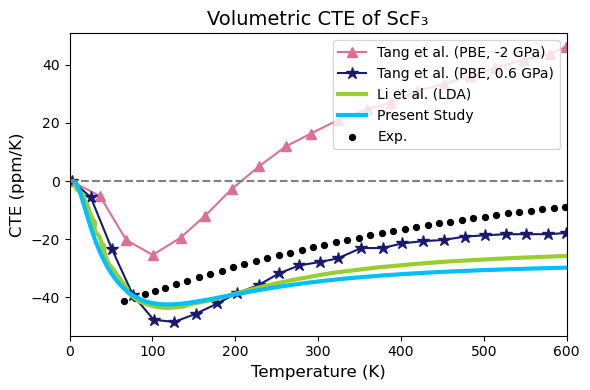

In [21]:
# colormap
cmap = plt.get_cmap('viridis') 
colors = [cmap(i / 5) for i in range(6)]  

# custom list of colors
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

cte_vecs = np.array(cte_vecs)
vols = np.array(vols)
labels = [r"$\alpha_{xx}$", r"$\alpha_{yy}$", r"$\alpha_{zz}$", 
          r"2$\alpha_{yz}$", r"2$\alpha_{xz}$", r"2$\alpha_{xy}$"]

plt.figure(figsize=(6, 4))
#for i in range(6):
#    plt.plot(temps, cte_vecs[:, i] * 1e6, label=labels[i], color=colors[i])

# Plot volumetric CTE
#plt.plot(temps, vols * 1e6, label='Volumetric', color='turquoise', linewidth=2)

plt.plot(lowpbe["lowpbe-Temp"], np.array(lowpbe["lowpbe-CTE"]) * 3, color='palevioletred', label = "Tang et al. (PBE, -2 GPa)", marker='^', linestyle = '-', markersize = 7)
plt.plot(highpbe["highpbe-Temp"], np.array(highpbe["highpbe-CTE"]) * 3, color='midnightblue', label = "Tang et al. (PBE, 0.6 GPa)", marker='*', linestyle = '-',markersize = 9)
plt.plot(lda["lda-Temp"], np.array(lda["lda-CTE"]) * 3, color='yellowgreen', label = "Li et al. (LDA)", lw = 3)
plt.plot(temps, vols * 1e6, label='Present Study', color='deepskyblue', linewidth=3)
plt.scatter(exp["exp-Temp"], np.array(exp["exp-CTE"]) * 3, marker='o', color='black', s = 18, label = "Exp.")


plt.xlabel("Temperature (K)", fontsize=12)
plt.ylabel("CTE (ppm/K)", fontsize=12)
plt.axhline(0, linestyle = '--', c = 'grey')
#plt.title("CTE of ScF₃", fontsize=14)
plt.title("Volumetric CTE of ScF₃", fontsize=14)
plt.legend(loc='upper right')
plt.xlim(0, 600)
plt.tight_layout()
#plt.savefig('/Users/admin/Documents/nte_figs/scf3_wref.png', dpi=600)
plt.show()


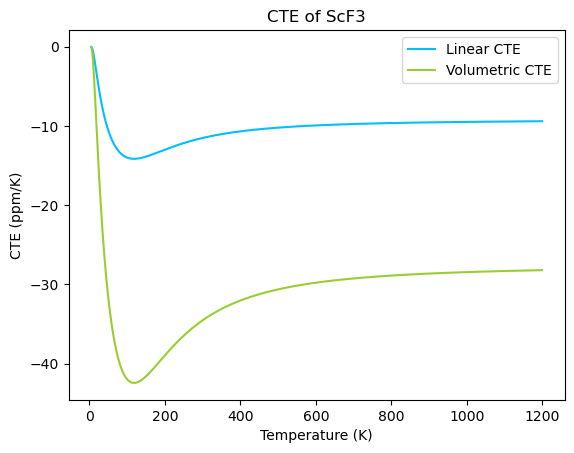

In [214]:
#cubic
# PARAMETERS
gfile = "/Users/admin/NREL/ScF3/16-gruneisen.hdf5"
stiffness_GPa = np.array([
    [235,  18,  18,   0,   0,   0],
    [ 18, 235,  18,   0,   0,   0],
    [ 18,  18, 235,   0,   0,   0],
    [  0,   0,   0,  18,   0,   0],
    [  0,   0,   0,   0,  18,   0],
    [  0,   0,   0,   0,   0,  18]])
stiffness = stiffness_GPa * 1e9

poscar_matrix = np.array([
                [ 2.8465005904369178,  1.6434278821371833,  2.3242469421120542],
                [-2.8465005904369178,  1.6434278821371833,  2.3242469421120542],
                [-1.0e-16,            -3.2868557642743665,  2.3242469421120542]])

V = np.linalg.det(poscar_matrix) * 1e-30 # volume of primitive cell in m^3

# RUN
temps = np.arange(5, 1200)
cte_lins = []
cte_vols = []

for t in temps:
    cte_lin, cte_vol = get_cte(gfile, stiffness, t, V, iso = True, tetra = False)
    cte_lins.append(cte_lin)
    cte_vols.append(cte_vol)

plt.plot(temps, np.array(cte_lins) * 1e6, label = 'Linear CTE', c = 'deepskyblue')
#plt.plot(temps, np.array(alphas) * 10**(6), label = "Old Linear CTE")
plt.plot(temps, np.array(cte_vols) * 1e6, label = 'Volumetric CTE', c = 'yellowgreen')
plt.xlabel("Temperature (K)")
plt.ylabel("CTE (ppm/K)")
plt.title("CTE of ScF3")
plt.legend()
plt.show()

## PbTiO3 (tetragonal)

In [21]:
#TiPbO3 (tetragonal)
#gfile = '/Users/admin/NREL/TiPbO3/2-anharm/4-smallts/16-gruneisen.hdf5'
#gfile = '/Users/admin/NREL/TiPbO3/2-anharm/4-smallts/20-gruneisen.hdf5'
gfile = '/Users/admin/NREL/TiPbO3/2-anharm/3-LASSO/old-fit/16-gruneisen.hdf5'
#gfile = '/Users/admin/NREL/TiPbO3/2-anharm/6-checkfcs/gruneisen.hdf5'
#gfile = '/Users/admin/NREL/TiPbO3/2-anharm/2-redo/old-gruneisen.hdf5'

stiffness_GPa = np.array([
    [176,  76,  46,   0,   0,   0],
    [ 76, 176,  46,   0,   0,   0],
    [ 46,  46,  49,   0,   0,   0],
    [  0,   0,   0,  35,   0,   0],
    [  0,   0,   0,   0,  35,   0],
    [  0,   0,   0,   0,   0,  86]]) 

stiffness = stiffness_GPa * 1e9

poscar_matrix = np.array([
                [ 3.8795519000000009,  0,  0],
                [0,  3.8795519000000009,  0],
                [0,            0,  4.2858876200000005]])

#poscar_matrix = np.array([
#                [ 3.8769228934107276,  0,  0],
#                [0,  3.8769228934107276,  0],
#                [0,            0,  4.1761735094846637]])

V = np.linalg.det(poscar_matrix) * 1e-30 # volume of primitive cell in m^3
#T = 300

# RUN
temps = np.arange(4, 800)
cte_vecs = []
vols = []

for t in temps:
    cte_lin_xx, cte_lin_zz, cte_vol, cte_vec  = get_cte(gfile, stiffness, t, V, iso = False, tetra = True)
    cte_vecs.append(cte_vec)
    #vol = 2*np.array(cte_vec[0]) + cte_vec[2]
    vol = cte_vec[0] + cte_vec[1] + cte_vec[2]
    vols.append(vol)

av_vols = []
av_temps = np.arange(300, 763)
for t_av in av_temps:
    av_cte_lin_xx, av_cte_lin_zz, av_cte_vol, av_cte_vec  = get_cte(gfile, stiffness, t_av, V, iso = False, tetra = True)
    #vol = 2*np.array(cte_vec[0]) + cte_vec[2]
    av_vol = av_cte_vec[0] + av_cte_vec[1] + av_cte_vec[2]
    av_vols.append(av_vol)

avg = np.mean(av_vols)
print('average volumetric CTE in cubic region:',avg)

print(f'Volumetric CTE Minima: {float(np.min(np.array(vols))) * 1e6} ppm/K')

average volumetric CTE in cubic region: -5.1965734973363394e-05
Volumetric CTE Minima: -80.276438868629 ppm/K


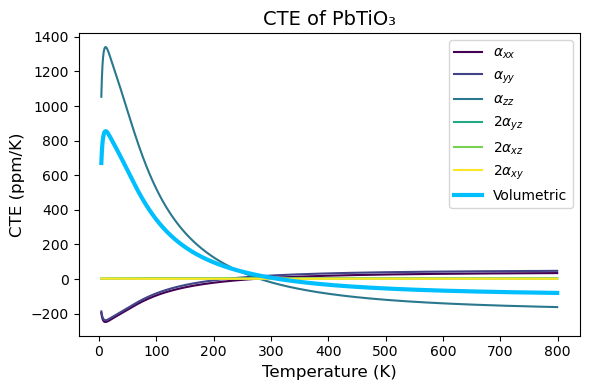

In [26]:
# colormap
cmap = plt.get_cmap('viridis') 
colors = [cmap(i / 5) for i in range(6)]  

# custom list of colors
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
labels = [r"$\alpha_{xx}$", r"$\alpha_{yy}$", r"$\alpha_{zz}$", 
          r"2$\alpha_{yz}$", r"2$\alpha_{xz}$", r"2$\alpha_{xy}$"]
cte_vecs = np.array(cte_vecs)
vols = np.array(vols)

plt.figure(figsize=(6, 4))
for i in range(6):
    plt.plot(temps, cte_vecs[:, i] * 1e6, label=labels[i], color=colors[i])

# Plot volumetric CTE
plt.plot(temps, np.array(vols) * 1e6, label='Volumetric', color='deepskyblue', linewidth=3)
#plt.axhline(avg*1e6, label = 'Present Study: Avg. for 300K < T < 763K', linestyle = '--', c = 'yellowgreen', linewidth=2)
#plt.axhline(-16.2, label = 'Experiment: Avg. for 300K < T < 763K', linestyle = '--', c = 'black', linewidth=2)
#plt.title("CTE of PbTiO₃", fontsize=14)
plt.title("CTE of PbTiO₃", fontsize=14)
plt.legend(loc='upper right')
plt.xlabel("Temperature (K)", fontsize=12)
plt.ylabel("CTE (ppm/K)", fontsize=12)
#plt.ylim(-85, 20)
#plt.xlim(300, 763)
plt.tight_layout()
plt.savefig('/Users/admin/Documents/nte_figs/PbTiO3.png', dpi=600)
plt.show()


Volumetric CTE Minima: -10.288064111999889 ppm/K


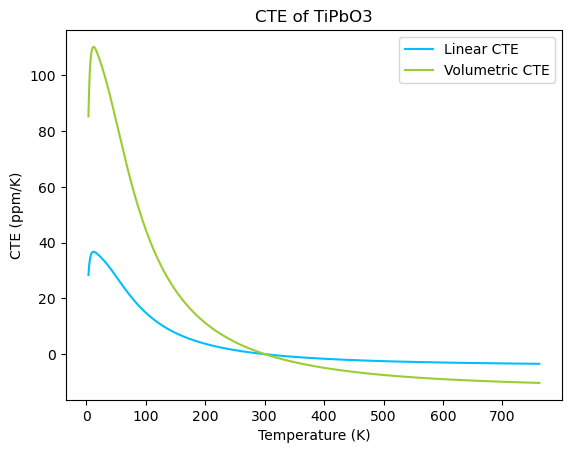

In [135]:
#TiPbO3 (iso treatment)
#gfile = '/Users/admin/NREL/TiPbO3/2-anharm/4-smallts/4-gruneisen.hdf5'
#gfile = '/Users/admin/NREL/TiPbO3/2-anharm/3-LASSO/16-gruneisen.hdf5'
#gfile = '/Users/admin/NREL/TiPbO3/2-anharm/3-LASSO/-gruneisen.hdf5'
gfile = "/Users/admin/NREL/TiPbO3/2-anharm/4-smallts/16-gruneisen.hdf5"
#gfile = '/Users/admin/NREL/TiPbO3/2-anharm/4-smallts/15-gruneisen.hdf5'
#gfile = '/Users/admin/NREL/TiPbO3/2-anharm/4-smallts/18-gruneisen.hdf5'
#gfile = '/Users/admin/NREL/TiPbO3/2-anharm/4-smallts/16-gruneisen.hdf5'

stiffness_GPa = np.array([
    [176,  76,  46,   0,   0,   0],
    [ 76, 176,  46,   0,   0,   0],
    [ 46,  46,  49,   0,   0,   0],
    [  0,   0,   0,  35,   0,   0],
    [  0,   0,   0,   0,  35,   0],
    [  0,   0,   0,   0,   0,  86]]) 


stiffness = stiffness_GPa * 1e9

poscar_matrix = np.array([
                [ 3.8795519000000009,  0,  0],
                [0,  3.8795519000000009,  0],
                [0,            0,  4.2858876200000005]])
V = np.linalg.det(poscar_matrix) * 1e-30 # volume of primitive cell in m^3

# RUN
temps = np.arange(4, 763)
cte_lins = []
cte_vols = []

for t in temps:
    cte_lin, cte_vol = get_cte(gfile, stiffness, t, V, iso = True, tetra = False)
    cte_lins.append(cte_lin)
    cte_vols.append(cte_vol)

print(f'Volumetric CTE Minima: {float(np.min(np.array(cte_vols))) * 1e6} ppm/K')

plt.plot(temps, np.array(cte_lins) * 1e6, label = 'Linear CTE', c = 'deepskyblue')
plt.plot(temps, np.array(cte_vols) * 1e6, label = 'Volumetric CTE', c = 'yellowgreen')
plt.xlabel("Temperature (K)")
plt.ylabel("CTE (ppm/K)")
plt.title("CTE of TiPbO3")
plt.legend()
plt.show()

## ZnF2 (tetragonal)

In [4]:
## ZnF2 (tetragonal)
gfile = "/Users/admin/NREL/ZnF2/2-anharm/1-50TS/gruneisen.hdf5"
gfile = '/Users/admin/NREL/ZnF2/2-anharm/2-4TS/gruneisen.hdf5'
stiffness_GPa = np.array([
    [178,  79,  79,   0,   0,   0],
    [ 79, 112,  77,   0,   0,   0],
    [ 79,  77, 112,   0,   0,   0],
    [  0,   0,   0,  74,   0,   0],
    [  0,   0,   0,   0,  33,   0],
    [  0,   0,   0,   0,   0,  33]
])
stiffness = stiffness_GPa * 1e9

poscar_matrix = np.array([
                [ 4.7190390199941525,  0,  0],
                [0,  4.7190390199941525,  0],
                [0,            0,  3.1380763361300263]])


V = np.linalg.det(poscar_matrix) * 1e-30 # volume of primitive cell in m^3
print(f'Volume of Primitive Cell = {V}')

# RUN
temps = np.arange(5, 140)
cte_vecs = []
vols = []

for t in temps:
    cte_lin_xx, cte_lin_zz, cte_vol, cte_vec  = get_cte(gfile, stiffness, t, V, iso = False, tetra = True)
    cte_vecs.append(cte_vec)
    vol = cte_vec[2] + cte_vec[1]+ cte_vec[0]
    vols.append(vol)
print(f'Volumetric CTE Minima: {float(np.min(np.array(vols))) * 1e6} ppm/K')

Volume of Primitive Cell = 6.988285521066442e-29
Volumetric CTE Minima: -1.7441734493041585 ppm/K


In [6]:
#reference data 
obs = np.array([
    [1.8379741322444545, 0.39324487487681203],
    [3.8757695033915027, 0.08682355290979515],
    [6.172416584455835, -0.26194865231050457],
    [8.435991567686674, -0.5046607079390277],
    [9.52199331581905, -0.7977571298908508],
    [11.62181519277809, -0.9427400313637015],
    [13.197871000776434, -1.2117477203551559],
    [15.315850859543051, -1.3590945426460124],
    [17.227617191033378, -1.5609672857985508],
    [19.557500902954555, -1.6734247453163533],
    [22.049403148842227, -1.7831882808634454],
    [24.611676455801625, -1.8790830798801679],
    [27.115682978702072, -1.9455250352219444],
    [29.61861303427924, -1.9898097048264347],
    [32.119892506627394, -2.000119869633746],
    [34.61930610228188, -1.9720240724964206],
    [37.11771499510134, -1.9232481420042937],
    [39.614401540203545, -1.839020554332503],
    [42.10993985349427, -1.7311585285409343],
    [44.6809146046501, -1.616200788976819],
    [47.101167563208804, -1.5185442714472437],
    [49.59368421383772, -1.3484863558667861],
    [52.08448607090605, -1.1431322728311493],
    [54.57489322328921, -0.9296538516918389],
    [57.06422390834908, -0.6940181448152352],
    [59.552226950376905, -0.4310551188626377],
    [62.03933293630203, -0.14962768812896954],
    [64.52600833529785, 0.1406626568996181],
    [67.01182256043502, 0.44867883051803226],
    [69.49731384537525, 0.7633421898576369],
    [71.98119042933055, 1.111241477803178],
    [74.4652105422623, 1.456186460983746],
    [76.89601557850214, 1.782311491908871],
    [79.25946964254946, 2.157747696800751],
    [81.63585498390232, 2.489847833319308],
    [83.94524202426189, 2.863999994953545],
    [86.20090035923532, 3.2299043949555646],
    [88.4572296921736, 3.58199742018134],
    [90.66542998223457, 3.9395913822829343],
    [92.7892320236347, 4.310361036878298],
    [94.95009475758191, 4.65716449997414],
    [97.07427072973638, 5.020237413208129],
    [99.2347179850676, 5.375592811149941],
    [101.35777216495889, 5.761755948468055],
    [103.56526198658655, 6.133973719156261],
    [105.81989408937845, 6.521001398227829],
    [108.02769967475426, 6.886719698433097],
    [110.1041371539305, 7.2472547297876915],
    [112.133006948004, 7.601736083826221],
    [114.1617451738491, 7.958925550565974],
    [116.238055701226, 8.322073673123507],
    [118.398627600142, 8.674863490611529],
    [120.47469576499294, 9.043000241829212],
    [122.50356555906644, 9.397481595867738],
    [124.53261077744448, 9.748352132971302],
    [126.6089836266138, 10.110217465301938],
    [128.76997100414576, 10.454455347943988],
    [130.89398078485388, 10.820949035116364],
    [133.05509280597065, 11.162621337304625],
    [135.13157183300854, 11.522301175174624],
    [137.26242454652214, 11.88340333484006],
    [139.02632031420652, 12.076548783336325]
])

import matplotlib.pyplot as plt

# calc
calc_temps = [0.045422021270422164, 2.01654786243229, 7.015167473738622, 11.910426547801077,
     15.443260734541976, 20.51153328797597, 25.48509692433132, 30.548343086345096,
     36.33146326218555, 39.84926876901882, 44.87703499020169, 49.88655509025516,
     51.706473805666874, 54.89284578833879, 57.307846404726945, 59.89224709555353,
     62.201066171249195, 64.88648135961657, 66.97507196601862, 69.89629955831339,
     72.30642708993427, 74.90530204481836, 79.84706274831248, 84.34329473390795,
     89.06782468335312, 94.26683094071402, 98.75122551963, 103.94541453325986,
     108.91275222255449, 113.65394490116104, 118.35460971817004, 122.90835714177577,
     128.13315077190296, 132.84132905803938, 139.27702357342187]

calc_data = [-0.048465627232463504, -0.06525030225872541, -0.00478601959609648, -0.15656093507402247,
     -0.3420133301062265, -0.7300835772230769, -1.139039005834423, -1.5830127033630284,
     -2.1177717676930463, -2.2863517833442586, -2.53335393858913, -2.6972580493048923,
     -2.7213541722988666, -2.7946903028087853, -2.7839017080800232, -2.7503159275940234,
     -2.6987222442103374, -2.599586580840274, -2.538461178000638, -2.40966600303042,
     -2.2407222771324307, -2.097084598604102, -1.692066318677714, -1.2002923359100315,
     -0.6669944958421645, -0.05166816498247684, 0.5501514561842491, 1.2646327205080627,
     1.9689832312451134, 2.6486646991572425, 3.312848295344356, 4.020987105478865,
     4.789658899455198, 5.4647510598214435, 6.2663112562246575]


obs_temps = obs[:, 0]
obs_data = obs[:, 1]

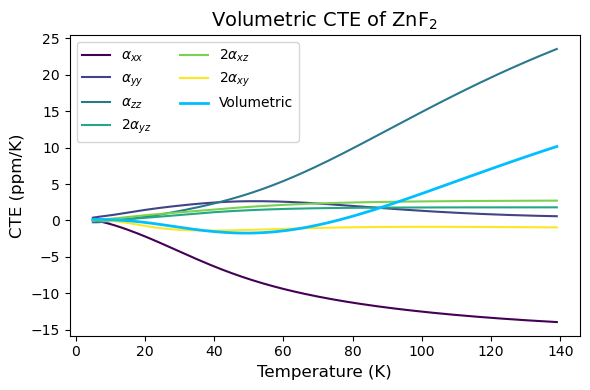

In [10]:
# colormap
cmap = plt.get_cmap('viridis') 
colors = [cmap(i / 5) for i in range(6)]  

# custom list of colors
#colors = ['yellowgreen', 'mediumaquamarine', 'steelblue', 'darkslateblue', 'mediumpurple', 'gold']

labels = [r"$\alpha_{xx}$", r"$\alpha_{yy}$", r"$\alpha_{zz}$", 
          r"2$\alpha_{yz}$", r"2$\alpha_{xz}$", r"2$\alpha_{xy}$"]

cte_vecs = np.array(cte_vecs)
vols = np.array(vols)

plt.figure(figsize=(6, 4))
for i in range(6):
    plt.plot(temps, cte_vecs[:, i] * 1e6, label=labels[i], color=colors[i])

# Plot volumetric CTE
plt.plot(temps, vols * 1e6, label='Volumetric', color='deepskyblue', linewidth=2)

#REFERENCE
#plt.scatter(obs_temps, obs_data, label='Chatterji et. al (Expt.)', linewidth=2.5, color='black', s = 18)
#plt.plot(calc_temps, calc_data, label='Chatterji et. al (Calculated)', linewidth=3, color = 'yellowgreen')

plt.xlabel("Temperature (K)", fontsize=12)
plt.ylabel("CTE (ppm/K)", fontsize=12)
plt.title(r"Volumetric CTE of ZnF$_2$", fontsize=14)
plt.legend(loc='upper left', ncol=2)
#plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('/Users/admin/Documents/nte_figs/ZnF2_TS=4.png', dpi=600)
plt.show()

Volume of Primitive Cell = 6.988285521066442e-29


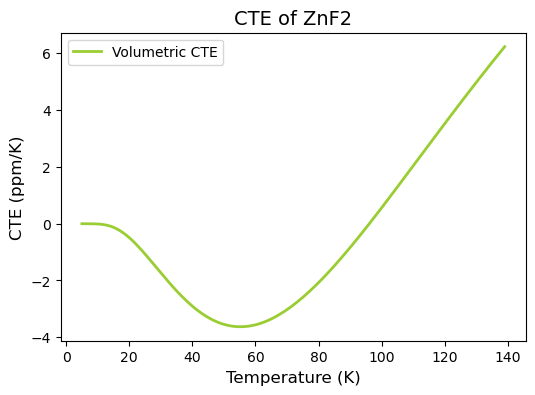

In [184]:
## ZnF2 (treat isotropically)
gfile = "/Users/admin/NREL/ZnF2/2-anharm/1-fitting/gruneisen.hdf5"
stiffness_GPa = np.array([
    [178,  79,  79,   0,   0,   0],
    [ 79, 112,  77,   0,   0,   0],
    [ 79,  77, 112,   0,   0,   0],
    [  0,   0,   0,  74,   0,   0],
    [  0,   0,   0,   0,  33,   0],
    [  0,   0,   0,   0,   0,  33]
])
stiffness = stiffness_GPa * 1e9

poscar_matrix = np.array([
                [ 4.7190390199941525,  0,  0],
                [0,  4.7190390199941525,  0],
                [0,            0,  3.1380763361300263]])


V = np.linalg.det(poscar_matrix) * 1e-30 # volume of primitive cell in m^3
print(f'Volume of Primitive Cell = {V}')

# RUN
temps = np.arange(5, 140)
cte_lins = []
ISO_VOL = []

for t in temps:
    cte_lin, cte_vol  = get_cte(gfile, stiffness, t, V, iso = True, tetra = False)
    cte_lins.append(cte_lin)
    ISO_VOL.append(cte_vol)

#plt.figure(figsize=(4,4))
plt.figure(figsize = (6,4))
#plt.plot(temps, np.array(cte_lins) * 1e6, label = 'XX Linear CTE', linewidth = 2, c = 'deepskyblue')
plt.plot(temps, np.array(ISO_VOL) * 1e6, label = 'Volumetric CTE', linewidth = 2, c = 'yellowgreen')
#plt.plot(temps, np.array(cte_vols) * 1e6, label = 'Volumetric CTE')
plt.xlabel("Temperature (K)", fontsize = 12)
plt.ylabel("CTE (ppm/K)", fontsize = 12)
#plt.ylim(-5,15)
plt.title("CTE of ZnF2", fontsize = 14)
plt.legend()
plt.show()

## Cu2O (cubic)

Volume of Primitive Cell = 7.65869082712687e-29


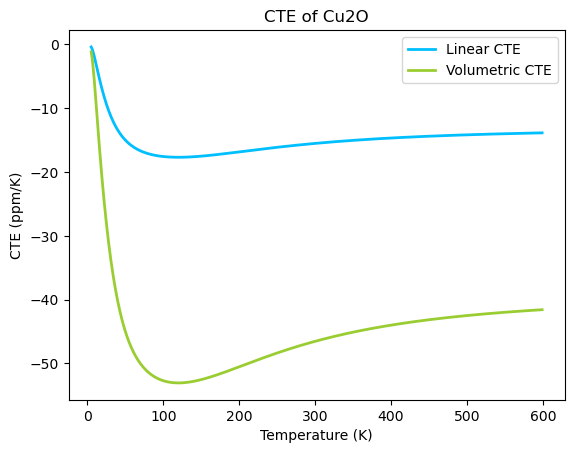

In [11]:
# PARAMETERS
#gfile = "/Users/admin/NREL/Cu2O/2-anharm/1-jun25/nosymm-gruns/16-gruneisen.hdf5"
#gfile = '/Users/admin/NREL/Cu2O/2-anharm/2-smallerts/sym-gruneisen.hdf5'
#gfile = '/Users/admin/NREL/Cu2O/2-anharm/2-smallerts/gruneisen.hdf5'
#gfile = '/Users/admin/NREL/Cu2O/2-anharm/1-jun25/nosymm-gruns/2-gruneisen.hdf5'
gfile = '/Users/admin/NREL/Cu2O/4-conventional-fitting/2-triplerelax/gruneisen.hdf5'

stiffness_GPa = np.array([
    [124, 106, 106,   0,   0,   0],
    [106, 124, 106,   0,   0,   0],
    [106, 106, 124,   0,   0,   0],
    [  0,   0,   0,   7,   0,   0],
    [  0,   0,   0,   0,   7,   0],
    [  0,   0,   0,   0,   0,   7]
])
stiffness = stiffness_GPa * 1e9

poscar_matrix = np.array([
                [ 4.2466993200000003,  0,  0],
                [0,  4.2466993200000003,  0],
                [0,            0,  4.2466993200000003]])


V = np.linalg.det(poscar_matrix) * 1e-30 # volume of primitive cell in m^3
print(f'Volume of Primitive Cell = {V}')

# RUN
temps = np.arange(5, 600)
cte_lins = []
cte_vols = []

for t in temps:
    cte_lin, cte_vol = get_cte(gfile, stiffness, t, V, iso = True, tetra = False)
    cte_lins.append(cte_lin)
    cte_vols.append(cte_vol)

plt.plot(temps, np.array(cte_lins) * 1e6, label = 'Linear CTE',linewidth = 2, c = 'deepskyblue')
plt.plot(temps, np.array(cte_vols) * 1e6, label = 'Volumetric CTE', linewidth = 2, c = 'yellowgreen')
plt.xlabel("Temperature (K)")
plt.ylabel("CTE (ppm/K)")
plt.title("CTE of Cu2O")
plt.legend()
plt.show()

In [31]:
#PARAMETERS
#gfile = "/Users/admin/NREL/Cu2O/2-anharm/1-jun25/nosymm-gruns/20-gruneisen.hdf5"
#gfile = '/Users/admin/NREL/Cu2O/2-anharm/2-smallerts/2-gruneisen.hdf5'
#gfile = '/Users/admin/NREL/Cu2O/2-anharm/2-smallerts/sym-gruneisen.hdf5'
#gfile = '/Users/admin/NREL/Cu2O/2-anharm/2-smallerts/gruneisen.hdf5'
#gfile = '/Users/admin/NREL/Cu2O/2-anharm/1-jun25/nosymm-gruns/2-gruneisen.hdf5'
#gfile = '/Users/admin/NREL/Cu2O/2-anharm/5-jul22-fit/18-gruneisen.hdf5'
#gfile = '/Users/admin/NREL/Cu2O/4-conventional-fitting/16-gruneisen.hdf5'
gfile = '/Users/admin/NREL/Cu2O/4-conventional-fitting/2-triplerelax/gruneisen_TS50.hdf5'

stiffness_GPa = np.array([
    [124, 106, 106,   0,   0,   0],
    [106, 124, 106,   0,   0,   0],
    [106, 106, 124,   0,   0,   0],
    [  0,   0,   0,   7,   0,   0],
    [  0,   0,   0,   0,   7,   0],
    [  0,   0,   0,   0,   0,   7]
])
stiffness = stiffness_GPa * 1e9

poscar_matrix = np.array([
                [ 4.2466993200000003,  0,  0],
                [0,  4.2466993200000003,  0],
                [0,            0,  4.2466993200000003]])


V = np.linalg.det(poscar_matrix) * 1e-30 # volume of primitive cell in m^3
print(f'Volume of Primitive Cell = {V}')


# RUN
temps = np.arange(5, 500)
cte_vecs = []
vols = []

for t in temps:
    cte_lin_xx, cte_lin_zz, cte_vol, cte_vec  = get_cte(gfile, stiffness, t, V, iso = False, tetra = True)
    cte_vecs.append(cte_vec)
    #vol = 2*np.array(cte_vec[0]) + cte_vec[2]
    vol = cte_vec[0] + cte_vec[1] + cte_vec[2]
    vols.append(vol)

print(f'Volumetric CTE Minima: {float(np.min(np.array(vols))) * 1e6} ppm/K')

Volume of Primitive Cell = 7.65869082712687e-29
Volumetric CTE Minima: -35.03018598947932 ppm/K


In [29]:
#reference
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

# Raw data as provided
exp_shafer = """-1.7278261097364407, -0.13322225847450042
1.3847970804328895, -0.6074423847934582
6.460058628890508, -0.8961345781284038
7.2615960127183, -1.4128959743755765
9.842748432262042, -1.8433214152701574
13.14710943993407, -2.285593347892462
16.39121014531314, -2.7987283107824155
20.541081064616975, -3.3584243755016097
25.116356780729305, -3.9105110142926023
29.71390126626291, -4.443627794435304
34.351921542664044, -5.014232461770387
39.29689602450124, -5.44275167481549
44.03645451826792, -5.684696743657202
45.43682141096504, -6.073086812559588
50.54905486584876, -6.545159661767894
56.17202393285338, -7.011578871326378
62.141232254576735, -7.526562990447658
71.1138578721624, -7.937380853926207
77.00642300373666, -8.13836426022996
82.12187554679026, -8.369249680138651
89.09941664265286, -8.451205748076315
95.27252084251741, -8.615585711934617
102.20362612735981, -8.693466318327275
108.46148618986722, -8.626695869595537
115.54527623951317, -8.573157013448991
122.43247384617713, -8.382389888612742
128.71479291350022, -8.18274915991303
135.34858038314843, -7.931682112064447
142.0730335568689, -7.561045585215513
148.31040323910128, -7.200483737678532
155.30779647909327, -6.766456483808696
161.6432263150249, -6.2605499158126925
167.1177010076281, -5.759245595943774
171.94766970630104, -5.230615910303932
177.9662329888838, -4.865669329110979
183.784355892694, -4.340169913751488
188.7393241675935, -3.7750533636158963
194.4948840210563, -3.296490590486915
198.7969865228854, -2.672839101017633
201.5556193278087, -2.1058586166501705
207.08399890409004, -1.7836494274553303
211.4740138653051, -1.1956069014808683
216.85419067056927, -0.8108688622844866
218.8285573604956, -0.26316539532313854
224.1076375079286, 0.20266400781355642
229.32242418874114, 1.0516775320430192
234.87067147699673, 1.4830442636562502
239.2776076037694, 2.068260257475842
243.90872589409003, 2.4079442485658547
245.79799234036835, 3.0342387727197817
250.84259088446782, 3.389118965255399
254.06093124302828, 3.9555298414757765
259.1758034778557, 4.4822472289773
263.0912598936299, 5.012785863623169
266.8173766423671, 5.59823474169459
272.4256812640106, 6.2446123782964005
278.3047517945728, 6.818042741774429
281.9658982303536, 7.327060405473064
286.52797987231264, 7.809225050481956
291.0333532906086, 8.262251610593395
294.3313340335051, 8.852700860766648
298.3219194230966, 9.29915636453702
303.40829449026535, 9.865726519648993
309.0545046364545, 10.311450707620626
314.06452546695976, 10.850770146011998
318.94650859055207, 11.382271344134955
324.3423546350904, 11.960499044690534
330.4007744756453, 12.547473054899973
336.7806849601862, 13.185847975271859
343.02308924632274, 13.603611492191757
348.57375123197505, 14.10733121393304
354.809725848352, 14.556985892860737
361.41615248934426, 15.080676018599366
368.04766450300474, 15.479942695903564
374.6905974993435, 15.822561299123791
380.9487163706689, 16.1623804735071
388.44220844635714, 16.551652661909415
394.625310925818, 16.82108149899099
401.3346429515538, 17.12259958536317
407.8785777414336, 17.34943104217413
414.5502349385683, 17.549577609446327
421.48993503168634, 17.684594126654872
428.06801032951734, 17.73940222906517
434.9813940085307, 17.816676477009047
441.74561016294064, 17.925658799517922
448.4885007513747, 17.950517512067737
454.94749474275847, 17.852447357328106
461.5202498794618, 17.937846939520018
468.5328465472882, 17.792047520648584
474.98212137305535, 17.75009686141645
482.0803372456127, 17.745989887494964
488.42013117069615, 17.680700795238312
493.46106740029546, 17.715116023042015"""

exp_dap = """
6.901382591811426, -0.2914035658195324
10.653740175475264, -0.7440610362138251
17.14798436850215, -1.8523426321443672
22.40542188580521, -2.411008241112814
26.350769775613045, -3.0619286270344475
31.26854566688486, -3.598108387218268
36.24080704929007, -4.16176832052825
42.34123812067695, -4.763043576476086
46.376185905908685, -5.361770096093132
52.178313635501226, -5.760760462396227
57.35279742162335, -6.265653549372946
62.32697194871808, -6.725511010991884
69.16003882026506, -7.14216051640992
75.47977202654947, -7.291744355817958
82.22610763065579, -7.462002687125164
88.45497207535136, -7.6142407196255775
95.52485760797056, -7.730818875102415
101.78877738384143, -7.644651891841509
109.00058586930108, -7.8537761965888
115.21252244533646, -7.643294866736387
122.27971435625314, -7.513434214762647
179.40702394476108, -5.616697002677647
184.89061862223133, -5.198459133050434
198.32245602294535, -3.9761959337647106
204.467065857534, -3.720012635298204
208.2795540845221, -3.363000712759831
214.7611595048133, -2.703597600081647
221.12717249915386, -2.385666172351627
224.9995735235297, -1.7953298324747848
231.35752563657803, -1.4227516591502756
237.06806987726725, -1.0486527938901133
242.18453360841215, -0.4962774645074539
248.54165562118897, -0.09796409366353487
254.2185665861141, 0.3450394480188308
260.75708440113425, 0.5161865339790452
265.2909407042415, 0.9624493642753151
267.21839400826605, 1.591517924104668
272.2048672719978, 1.9113548465709016
277.9821005456794, 2.3542540277100983
284.06995007311394, 2.9661475188788984
290.66617577172514, 3.4569968093917858
296.4054474010732, 3.98095144285384
302.10666619441815, 4.375068561407499
306.49338099581564, 4.964383788797502
311.2651949356503, 5.461384901535377
317.90077394502225, 5.840479280110841
324.5475240498322, 6.144253801470814
328.8617882620795, 6.709925704188798
335.47033630557905, 6.906596311494026
341.38287955141385, 7.383059188324756
346.21567240268877, 7.828161975009376
352.9741948173779, 7.994600387640748
359.3919468549941, 8.323627531241504
365.6055295747573, 8.761338901189085
372.1364707610626, 8.898385659741368
378.58043917119363, 9.333395170231922
385.5486189640385, 9.52615521289405
392.28037258872746, 9.687638301562314
405.3055810971856, 10.040980764163177
412.28466497824564, 10.273791155308901
418.81782012623063, 10.39985666392957
425.16563044573496, 10.613385836829682
432.1715052586463, 10.552661964048204
438.5873064252915, 10.625005508349412
445.3000705728628, 10.621261601456231
452.0138045975345, 10.612707104144803
458.72491451547177, 10.617168176236007
465.4411593434783, 10.5961600943839
472.1688918413068, 10.518173170214789
478.8894797504815, 10.475623405768847
485.6162119411536, 10.40259800509519
491.43663930281315, 10.285085520179155
171.7809843842657, -6.092745601897608
164.5819331883772, -6.385451670290571
152.59142122949203, -6.912512354220201
137.3275350859854, -7.20363708242736
127.68531330302433, -7.378217038940502
191.64657046847202, -4.626052579561179"""

cfc_data = """
6.458776681855198, -0.8897761208332611
13.331419371893574, -1.6865175983634089
18.125548748519606, -2.463953523296027
22.47921180670498, -3.1752307256303354
30.248580008906956, -3.8799717073472806
35.26184754832731, -4.5337305101012895
40.28079838627092, -5.215678473530414
63.62917215412351, -6.77300995244072
70.4902765115341, -6.75589479411293
77.21098096134834, -6.799022600131156
83.90666802053407, -6.7180641486321235
90.59936386997073, -6.622269296777759
97.28267819792173, -6.4799420983544245
103.95905835781808, -6.303221426380112
110.62932013413679, -6.096153571860807
117.29183195792389, -5.850645952784529
123.95108064380291, -5.588953169684256
130.60461883834284, -5.2989363495419965
137.2565254639287, -5.000826947387743
143.904761059368, -4.684509235706507
150.54728616346824, -4.33986748698328
157.18899548309145, -3.991179447254055
163.8290732337606, -3.6343988255128394
170.4675194154757, -3.269525621759623
177.1075971661449, -2.9127450000184076
183.74930648576805, -2.5640569602891823
190.39060791315273, -2.2133457750569576
197.48702360340752, -2.0392784420941297
203.40145094539628, -1.793651774762381
209.82237341398434, -1.3906503558505712
214.06833281223044, -0.9725893295600727
221.64621017603298, -0.6194462519549901
232.0796420420852, -0.1620393919114811
238.73154866767112, 0.1360700102427721
245.38590264668807, 0.42204053937902586
252.04379169177201, 0.6904771408226296
258.7015447727765, 0.9595881241005628
265.113284448329, 1.238323188782008
274.0776409452795, 1.56740412053432
280.44008213735935, 1.8578515075400368
287.0588306973695, 2.0488153999671326
293.83371116769547, 2.2413922028930457
300.5031571595372, 2.4525063484183462
307.17382682809443, 2.657551057434649
313.8461280656057, 2.854503184438954
320.51965297983253, 3.0453858749342615
327.1956252474904, 3.2241296924115765
333.8720054073868, 3.400850364385896
340.54920135176013, 3.5735247453542165
347.22884464956456, 3.734060253304545
353.910119516323, 3.8865031792428724
360.59180227531994, 4.036922959678204
367.2738929265554, 4.18531959461054
373.9576151467449, 4.325623647530879
380.64296893588846, 4.45783511843922
387.32832272503197, 4.590046589347562
394.01571597536804, 4.712142332740907
400.7035171179426, 4.832214930631256
407.3925419372327, 4.946218092012607
414.0815667565228, 5.060221253393959
420.7722231447669, 5.166131832763316
427.4645111019651, 5.263949830120676
434.1551674902092, 5.369860409490032
440.84867912412295, 5.461608970338398
447.5425986502751, 5.551334385683761
454.2361102841888, 5.643082946532125
460.93247716377203, 5.720669488859496
467.6259887976857, 5.81241804970786
474.32317146174597, 5.885958301029236
481.0191304490907, 5.965567988859606
487.716313113151, 6.03910824018098
493.20537723707076, 6.051904402406166
"""

# Convert to DataFrame
shaf = pd.read_csv(StringIO(exp_shafer), header=None, names=["shaf-Temp", "shaf-CTE"])
dap = pd.read_csv(StringIO(exp_dap), header=None, names=["dap-Temp", "dap-CTE"])
cfc = pd.read_csv(StringIO(cfc_data), header=None, names=["cfc-Temp", "cfc-CTE"])

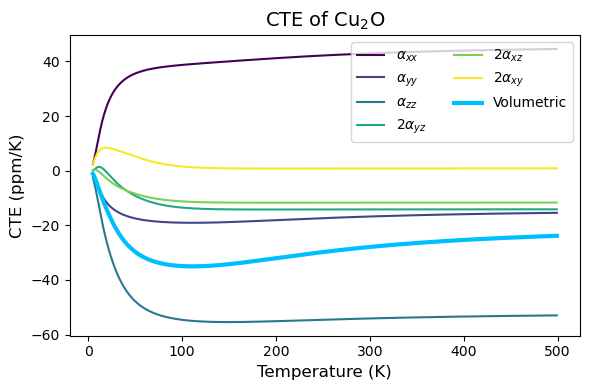

In [17]:
# colormap
cmap = plt.get_cmap('viridis') 
colors = [cmap(i / 5) for i in range(6)]  

# custom list of colors
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
labels = [r"$\alpha_{xx}$", r"$\alpha_{yy}$", r"$\alpha_{zz}$", 
          r"2$\alpha_{yz}$", r"2$\alpha_{xz}$", r"2$\alpha_{xy}$"]

cte_vecs = np.array(cte_vecs)
vols = np.array(vols)

plt.figure(figsize=(6, 4))
for i in range(6):
    plt.plot(temps, cte_vecs[:, i] * 1e6, label=labels[i], color=colors[i])

# Plot volumetric CTE
#plt.plot(temps, vols * 1e6, label='Volumetric', color='turquoise', linewidth=2)
plt.plot(temps, vols * 1e6, label='Volumetric', color='deepskyblue', linewidth=3)
#plt.scatter(shaf["shaf-Temp"], shaf["shaf-CTE"], marker='o', color='black', s = 18, label = "Exp. Schafer")
#plt.scatter(dap["dap-Temp"], dap["dap-CTE"], marker='o', color='white', edgecolors = 'black', s = 18, label = "Exp. Dapiaggi")
#plt.scatter(cfc["cfc-Temp"], cfc["cfc-CTE"], marker='o', color='green', s = 15, label = "CFC Linnera")
#plt.plot(cfc["cfc-Temp"], cfc["cfc-CTE"], color='yellowgreen', label = "CFC Linnera", linewidth = 3)

plt.xlabel("Temperature (K)", fontsize=12)
plt.ylabel("CTE (ppm/K)", fontsize=12)
plt.title(r"CTE of Cu$_2$O", fontsize=14)
#plt.title(r"Volumetric CTE of Cu$_2$O", fontsize=14)
plt.legend(loc='upper right', ncols = 2)
plt.tight_layout()
plt.savefig('/Users/admin/Documents/nte_figs/Cu2O.png', dpi=600)
plt.show()

In [6]:
G = check_G("/Users/admin/NREL/Cu2O/2-anharm/1-jun25/nosymm-gruns/16-gruneisen.hdf5", 'Cu2O', 1, 1)
G

array([[ -0.69723083,   0.        ,   0.        ],
       [  0.        , -42.43510701,  -4.15503444],
       [  0.        ,  -4.15503444, -24.26989858]])

# Grüneisen Tensor Checks

In [4]:
def check_G(infile, system, q, m):    
    '''
    infile: gruniesen.hdf5
    system: just a label when printing
    '''   
    # Load Data
    with h5py.File(infile) as f:
        #pprint.pprint(list(f.keys()))
        freqs_thz = f["frequency"][()] # THZ
        G = np.array(f["gruneisen_tensor"][()]) # Gruneisen TENSOR
        weights = f["weight"][()]

        #G_mod = G[4,3]
        G_mod = G[q,m]
        G_mod[np.abs(G_mod) <= 1e-10] = 0.0 # zero out elements with magnitude ≤ 1e-10 (noise)
        #print('Shape: ', G.shape)
        #print(f'Gruneisen Tensor for {system}:')
        #print(G_mod)
        #print('\n')
        return G_mod

In [80]:
g16 = check_G("/Users/admin/NREL/Cu2O/2-anharm/1-jun25/nosymm-gruns/16-gruneisen.hdf5", 'Cu2O - 16 mesh')

Shape:  (165, 18, 3, 3)
Gruneisen Tensor for Cu2O - 16 mesh:
[[ -0.69723083   0.           0.        ]
 [  0.         -42.43510701  -4.15503444]
 [  0.          -4.15503444 -24.26989858]]




In [69]:
g8 = check_G('/Users/admin/NREL/Cu2O/2-anharm/1-jun25/nosymm-gruns/8-gruneisen.hdf5', 'Cu2O - 8 mesh')

Shape:  (35, 18, 3, 3)
Gruneisen Tensor for Cu2O - 8 mesh:
[[ -1.1349822    0.           0.        ]
 [  0.         -31.66579572   6.21145163]
 [  0.           6.21145163 -31.24467681]]




In [70]:
g20 = check_G('/Users/admin/NREL/Cu2O/2-anharm/1-jun25/nosymm-gruns/20-gruneisen.hdf5', 'Cu2O - 20 mesh')

Shape:  (286, 18, 3, 3)
Gruneisen Tensor for Cu2O - 20 mesh:
[[ -0.65356324   0.           0.        ]
 [  0.         -18.83119385  -2.09929527]
 [  0.          -2.09929527 -49.0192859 ]]




In [71]:
g4 = check_G('/Users/admin/NREL/Cu2O/2-anharm/1-jun25/nosymm-gruns/4-gruneisen.hdf5', 'Cu2O - 4 mesh')

Shape:  (10, 18, 3, 3)
Gruneisen Tensor for Cu2O - 4 mesh:
[[ -2.54609435   0.           0.        ]
 [  0.         -27.77411987  -9.29516588]
 [  0.          -9.29516588 -27.05001911]]




In [72]:
g2 = check_G('/Users/admin/NREL/Cu2O/2-anharm/1-jun25/nosymm-gruns/2-gruneisen.hdf5', 'Cu2O - 2 mesh')

Shape:  (4, 18, 3, 3)
Gruneisen Tensor for Cu2O - 2 mesh:
[[ -4.60367063   0.           0.        ]
 [  0.         -23.17174138  13.79637762]
 [  0.          13.79637762 -23.17174138]]




In [73]:
g6 = check_G('/Users/admin/NREL/Cu2O/2-anharm/1-jun25/nosymm-gruns/6-gruneisen.hdf5', 'Cu2O - 6 mesh')

Shape:  (20, 18, 3, 3)
Gruneisen Tensor for Cu2O - 6 mesh:
[[ -1.55613329   0.           0.        ]
 [  0.         -26.07268168   5.25530391]
 [  0.           5.25530391 -34.21284115]]




In [74]:
g32 = check_G('/Users/admin/NREL/Cu2O/2-anharm/1-jun25/nosymm-gruns/32-gruneisen.hdf5', 'Cu2O - 32 mesh')

Shape:  (969, 18, 3, 3)
Gruneisen Tensor for Cu2O - 32 mesh:
[[ -0.65721744   0.           0.        ]
 [  0.         -33.02427137  -5.0515661 ]
 [  0.          -5.0515661  -38.83393248]]




In [ ]:
def check_FCs(infile, system):    
    '''
    infile: fc.hdf5
    system: just a label when printing
    '''   
    # Load Data
    with h5py.File(infile) as f:
        #pprint.pprint(list(f.keys()))
        freqs_thz = f["frequency"][()] # THZ
        G = np.array(f["gruneisen_tensor"][()]) # Gruneisen TENSOR
        weights = f["weight"][()]

        G_mod = G[1,1]
        G_mod[np.abs(G_mod) <= 1e-10] = 0.0 # zero out elements with magnitude ≤ 1e-10 (noise)
        print(f'Gruneisen Tensor for {system}:')
        print(G_mod)
        print('\n')
        return G_mod

In [64]:
 with h5py.File('/Users/admin/NREL/Cu2O/2-anharm/1-jun25/fc3.hdf5') as f:
     #pprint.pprint(list(f.keys()))
     fc3 = f["fc3"][()]

     print(fc3.shape)

(162, 162, 162, 3, 3, 3)


In [65]:
import numpy as np

def check_fc3_symmetry(infile, threshold=1e-8):

    with h5py.File(infile) as f:
     #pprint.pprint(list(f.keys()))
     fc3 = f["fc3"][()]

     print(fc3.shape)
    
    natoms = fc3.shape[0]
    max_diff = 0
    count_violations = 0

    for i in range(natoms):
        for j in range(natoms):
            for k in range(natoms):
                # geall 6 permutations
                a = fc3[i, j, k]
                b = np.transpose(fc3[j, i, k], (1, 0, 2))  # swap i<->j, α<->β
                c = np.transpose(fc3[k, j, i], (2, 1, 0))  # i->k, j->j, k->i
                # You can add more permutations if needed

                diff_ij = np.abs(a - b).max()
                diff_ki = np.abs(a - c).max()

                if diff_ij > threshold or diff_ki > threshold:
                    count_violations += 1
                    max_diff = max(max_diff, diff_ij, diff_ki)

    print(f"FC3 symmetry violations: {count_violations}")
    print(f"Max diff in violation: {max_diff:.2e}")

In [66]:
check_fc3_symmetry('/Users/admin/NREL/Cu2O/2-anharm/1-jun25/fc3.hdf5')

(162, 162, 162, 3, 3, 3)
FC3 symmetry violations: 0
Max diff in violation: 0.00e+00
